# **TimeCitedFiveYearCNT prediction :**

Some basic setup :

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


# importing alll the necessary packages to use the various classification algorithms
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb


Input data :

In [2]:
#讀取表格
patent_data = pd.read_csv('/home/wang/Desktop/Auberon/paper/1_CCVAE/patent_top500_2013.csv')

#包含所有跟五年被引證資料正相關的欄位們
df = pd.DataFrame(patent_data,columns=['PatentNumber','TimeCitedFiveYearCNT','ForeignRefCNT','SUM_For_distance_5Y','ReferenceCNT',\
                                    'GeneralityFiveYear5Class_cpc','GeneralityFiveYear5Class',\
                                    'GeneralityTenYear5Class','Generality5Class','GeneralityFiveYear4Class',\
                                    'GeneralityTenYear4Class','Generality4Class','GeneralityFiveYear4Class_cpc',\
                                    'SUM_Back_distance','GeneralityFiveYear3Class','GeneralityTenYear3Class',\
                                    'Generality3Class','GeneralityFiveYear3Class_cpc','Ass_Generality_5Y',\
                                    'Industry_Generality_5Y','NPRCNT','Ass_Originality','AssAssDistance',\
                                    'Originality5Class','ClaimCNT','Originality5Class_cpc',\
                                    'InvCtry_Generality_5Y','CPCCNT','InventorCNT','Originality4Class',\
                                    'Originality4Class_cpc','AssAss_Cultural_Distance','InvInvDistance',\
                                    'Originality3Class_cpc','InventorCountryCNT'])

#訓練跟測試資料切割
train_data, test_data = train_test_split(df, test_size=0.2)

#將train/test dataset遇到的NAN值轉為0
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

#列出 all/train/test dataset筆數
print ('the length of all dataset: ')
print (len(df))
print ('the length of train dataset: ')
print (len(train_data))
print ('the length of test dataset: ')
print (len(test_data))


the length of all dataset: 
134755
the length of train dataset: 
107804
the length of test dataset: 
26951


In [49]:
#將資料存成csv file
train_data.to_csv('/home/wang/Desktop/Auberon/paper/1_CCVAE/CVAE/train_data.csv', index = False, header = True)
test_data.to_csv('/home/wang/Desktop/Auberon/paper/1_CCVAE/CVAE/test_data.csv', index = False, header = True)




In [3]:
train_data.head(5)

,PatentNumber,TimeCitedFiveYearCNT,ForeignRefCNT,SUM_For_distance_5Y,ReferenceCNT,GeneralityFiveYear5Class_cpc,GeneralityFiveYear5Class,GeneralityTenYear5Class,Generality5Class,GeneralityFiveYear4Class,...,Originality5Class_cpc,InvCtry_Generality_5Y,CPCCNT,InventorCNT,Originality4Class,Originality4Class_cpc,AssAss_Cultural_Distance,InvInvDistance,Originality3Class_cpc,InventorCountryCNT
88881,8575896,2.0,0.0,247360.2405,1.0,0.5,0.50000,0.50000,0.50000,0.00000,...,0.000000,0.5,10.0,3,0.000000,0.000000,0.0,8.59965,0.000000,1
24725,8599660,0.0,1.0,0.0000,6.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.666667,0.0,3.0,2,0.277778,0.000000,0.0,79.73560,0.000000,1
56204,8526337,2.0,2.0,41032.2304,0.0,0.5,0.50000,0.50000,0.50000,0.50000,...,0.000000,0.5,2.0,7,0.000000,0.000000,0.0,0.00000,0.000000,1
122144,8519696,0.0,0.0,0.0000,27.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.954733,0.0,2.0,1,0.773663,0.877915,0.0,0.00000,0.817558,1
85312,8561891,9.0,0.0,264120.8810,1.0,0.0,0.37037,0.37037,0.37037,0.37037,...,0.000000,0.0,1.0,5,0.000000,0.000000,0.0,528.21506,0.000000,1


TimeCitedFiveYearCNT：

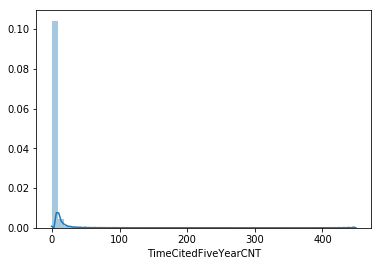

In [4]:
sns.distplot(train_data['TimeCitedFiveYearCNT']);

Apply **Log transfomation** to TimeCitedFiveYearCNT:

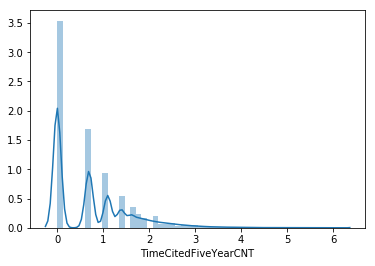

In [5]:
train_data['TimeCitedFiveYearCNT'] = np.log1p(train_data['TimeCitedFiveYearCNT'])
sns.distplot(train_data['TimeCitedFiveYearCNT']);

Now let's concat train data and test data, and save a copy of TimeCitedFiveYearCNT and PatentNumber :

In [6]:
# data preprocessing
PatentNumber = test_data['PatentNumber']
train_y = train_data.TimeCitedFiveYearCNT.values
# print(train_y)
all_data = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)
all_data.drop(['TimeCitedFiveYearCNT'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
all_data.head(5)

all_data size is : (134755, 34)


,PatentNumber,ForeignRefCNT,SUM_For_distance_5Y,ReferenceCNT,GeneralityFiveYear5Class_cpc,GeneralityFiveYear5Class,GeneralityTenYear5Class,Generality5Class,GeneralityFiveYear4Class,GeneralityTenYear4Class,...,Originality5Class_cpc,InvCtry_Generality_5Y,CPCCNT,InventorCNT,Originality4Class,Originality4Class_cpc,AssAss_Cultural_Distance,InvInvDistance,Originality3Class_cpc,InventorCountryCNT
0,8575896,0.0,247360.2405,1.0,0.5,0.50000,0.50000,0.50000,0.00000,0.00000,...,0.000000,0.5,10.0,3,0.000000,0.000000,0.0,8.59965,0.000000,1
1,8599660,1.0,0.0000,6.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.666667,0.0,3.0,2,0.277778,0.000000,0.0,79.73560,0.000000,1
2,8526337,2.0,41032.2304,0.0,0.5,0.50000,0.50000,0.50000,0.50000,0.50000,...,0.000000,0.5,2.0,7,0.000000,0.000000,0.0,0.00000,0.000000,1
3,8519696,0.0,0.0000,27.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.954733,0.0,2.0,1,0.773663,0.877915,0.0,0.00000,0.817558,1
4,8561891,0.0,264120.8810,1.0,0.0,0.37037,0.37037,0.37037,0.37037,0.37037,...,0.000000,0.0,1.0,5,0.000000,0.000000,0.0,528.21506,0.000000,1


**Handling missing value :**

1. drop columns that missing percent is too high or unnecessary :

In [7]:
# drop PatentNumber
all_data = all_data.drop('PatentNumber', axis=1)

# drop NAN that missing ratio is above a certain threshold
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100
# print(missing_ratio)
all_data = all_data.drop(missing_ratio[missing_ratio.values > 20].index, axis=1)
# all_data = all_data.drop(missing_data[missing_data.iloc[:] > 0].index, axis=1)
all_data.head(5)

,ForeignRefCNT,SUM_For_distance_5Y,ReferenceCNT,GeneralityFiveYear5Class_cpc,GeneralityFiveYear5Class,GeneralityTenYear5Class,Generality5Class,GeneralityFiveYear4Class,GeneralityTenYear4Class,Generality4Class,...,Originality5Class_cpc,InvCtry_Generality_5Y,CPCCNT,InventorCNT,Originality4Class,Originality4Class_cpc,AssAss_Cultural_Distance,InvInvDistance,Originality3Class_cpc,InventorCountryCNT
0,0.0,247360.2405,1.0,0.5,0.50000,0.50000,0.50000,0.00000,0.00000,0.00000,...,0.000000,0.5,10.0,3,0.000000,0.000000,0.0,8.59965,0.000000,1
1,1.0,0.0000,6.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.666667,0.0,3.0,2,0.277778,0.000000,0.0,79.73560,0.000000,1
2,2.0,41032.2304,0.0,0.5,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,...,0.000000,0.5,2.0,7,0.000000,0.000000,0.0,0.00000,0.000000,1
3,0.0,0.0000,27.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.954733,0.0,2.0,1,0.773663,0.877915,0.0,0.00000,0.817558,1
4,0.0,264120.8810,1.0,0.0,0.37037,0.37037,0.37037,0.37037,0.37037,0.37037,...,0.000000,0.0,1.0,5,0.000000,0.000000,0.0,528.21506,0.000000,1


2. deal with the rest of the missing value :

In [8]:
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100
print(missing_ratio)
all_data[missing_ratio.index].head(5)

Series([], dtype: float64)


""
0
1
2
3
4


In [9]:
all_data = pd.get_dummies(all_data)
all_data.head(5)

,ForeignRefCNT,SUM_For_distance_5Y,ReferenceCNT,GeneralityFiveYear5Class_cpc,GeneralityFiveYear5Class,GeneralityTenYear5Class,Generality5Class,GeneralityFiveYear4Class,GeneralityTenYear4Class,Generality4Class,...,Originality5Class_cpc,InvCtry_Generality_5Y,CPCCNT,InventorCNT,Originality4Class,Originality4Class_cpc,AssAss_Cultural_Distance,InvInvDistance,Originality3Class_cpc,InventorCountryCNT
0,0.0,247360.2405,1.0,0.5,0.50000,0.50000,0.50000,0.00000,0.00000,0.00000,...,0.000000,0.5,10.0,3,0.000000,0.000000,0.0,8.59965,0.000000,1
1,1.0,0.0000,6.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.666667,0.0,3.0,2,0.277778,0.000000,0.0,79.73560,0.000000,1
2,2.0,41032.2304,0.0,0.5,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,...,0.000000,0.5,2.0,7,0.000000,0.000000,0.0,0.00000,0.000000,1
3,0.0,0.0000,27.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.954733,0.0,2.0,1,0.773663,0.877915,0.0,0.00000,0.817558,1
4,0.0,264120.8810,1.0,0.0,0.37037,0.37037,0.37037,0.37037,0.37037,0.37037,...,0.000000,0.0,1.0,5,0.000000,0.000000,0.0,528.21506,0.000000,1


**Split to train and test data :**

In [10]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
# train, test = train_test_split(all_data, test_size=0.4998)
train = all_data[:ntrain]
test = all_data[ntrain:]
train_x = train
print(train_x.shape[0], train_y.shape[0])
# train_y


107804 107804


**Cross validation :**

In [11]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## **<font color='green'>Select an algorithm :</font>**

lightGBM:

In [73]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.2283 (0.0020)



svm-svr:

In [74]:
from sklearn import svm
clf = svm.SVR(kernel="rbf")

score = rmsle_cv(clf)
print("SVR score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/svm/

SVR score: 0.8478 (0.0051)



xgboost:

In [75]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

score = rmsle_cv(xgb_model)
print("XGBoost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[04:04:02] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:04] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:06] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:09] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:11] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
SVR score: 0.2131 (0.0013)



random forest:

In [81]:
from sklearn.ensemble import RandomForestRegressor 
# Set the random state for reproducibility
fit_rf = RandomForestRegressor(random_state=42)

score = rmsle_cv(fit_rf)
print("RandomForestClassifier  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/skl

RandomForestClassifier  score: 0.2278 (0.0013)



linear regression:

In [84]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

score = rmsle_cv(lr_model)
print("LinearRegression  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LinearRegression  score: 0.4145 (0.0041)



Ridge:

In [85]:
from sklearn.linear_model import (Ridge)

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True, alpha=0.1, fit_intercept=True, solver='sparse_cg') 
#paramters tuned using GridSearchCV

score = rmsle_cv(ridge)
print("ridge  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

ridge  score: 0.4202 (0.0038)



Lasso:

In [86]:
from sklearn.linear_model import (Lasso)

# create a lasso regressor
lasso = Lasso(alpha=0.2, normalize=True)

score = rmsle_cv(lasso)
print("lasso  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

lasso  score: 0.8685 (0.0049)



MLPRegressor:

In [87]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(
    hidden_layer_sizes=(200,), 
    activation="relu", 
    solver="adam", 
    alpha=0.0001, 
    batch_size=256, 
    learning_rate="constant", 
    learning_rate_init=0.001, 
    power_t=0.5, 
    momentum=0.9, 
    verbose=1, 
    early_stopping=True) # allow the model to stop early when it is no longer progressing

score = rmsle_cv(MLP)
print("MLP  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Iteration 1, loss = 85461132.77000065
Validation score: -937249123.073844
Iteration 2, loss = 470698844.64158261
Validation score: -98907351.235505
Iteration 3, loss = 195447104.78969291
Validation score: -52382858.536417
Iteration 4, loss = 98973001.46823898
Validation score: -2452560124.063461
Iteration 5, loss = 44218042.31752873
Validation score: -1057016.508131
Iteration 6, loss = 1401670.23399850
Validation score: -80480196.282794
Iteration 7, loss = 22066135.48021392
Validation score: -29283613.521547
Iteration 8, loss = 39107375.50912827
Validation score: -1166547.814607
Iteration 9, loss = 1025557.87864459
Validation score: -26089385.914133
Iteration 10, loss = 13852182.21750857
Validation score: -38893491.077569
Iteration 11, loss = 453966598.60506505
Validation score: -2391359414.469345
Iteration 12, loss = 7281237.56363817
Validation score: -20635061.172223
Iteration 13, loss = 8622911.37863024
Validation score: -13369204.109056
Iteration 14, loss = 231989493.76818117
Valid

decision tree:

In [88]:
from sklearn.tree import DecisionTreeRegressor
dtr= DecisionTreeRegressor()

score = rmsle_cv(dtr)
print("DecisionTreeRegressor  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

DecisionTreeRegressor  score: 0.3123 (0.0042)



SGDRegressor:

In [89]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

# Establish a model
model = SGDRegressor()

# Grid search - this will take about 1 minute.
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
SGD = GridSearchCV(model, param_grid)

score = rmsle_cv(SGD)
print("SGD  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max

SGD  score: 45668973.2106 (50937651.7843)



/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


ElasticNet:

In [90]:
from sklearn.linear_model import ElasticNet

ElasticNet = ElasticNet()

# ElasticNet = ElasticNet({'alpha': np.arange(1e-4,1e-3,1e-4),
#               'l1_ratio': np.arange(0.1,1.0,0.1),
#               'max_iter':[100000]})

score = rmsle_cv(ElasticNet)
print("ElasticNet  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

ElasticNet  score: 0.7688 (0.0162)



GradientBoostingRegressor(GBR):

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor()

score = rmsle_cv(GBR)
print("GBR  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

GBR  score: 0.2394 (0.0017)



# **Mean square error validation :**

In [13]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## **<font color='green'>Train the selected model :</font>**

lightGBM:

In [61]:
model.fit(train_x, train_y)
train_prediction = model.predict(train)
prediction = np.expm1(model.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.22585698075823024


(lightGBM) Done. Submit the answer.:

In [ ]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('lightGBM_submission.csv', index=False)

svm-svr:

In [14]:
clf.fit(train_x,train_y)
train_prediction = clf.predict(train)
prediction = np.expm1(clf.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.3642644600739715


(svm-svr) Done. Submit the answer.:

In [16]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('new-svm-svr_submission.csv', index=False)

xgboost:

In [29]:
xgb_model.fit(train_x,train_y)
train_prediction = xgb_model.predict(train)
prediction = np.expm1(xgb_model.predict(test))
#這邊values會出錯，把values去除
# prediction = np.expm1(xgb_model.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

[11:32:30] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
0.18364338621225512


(xgboost) Done. Submit the answer.:

In [30]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('xgboost_submission.csv', index=False)

random forest:

In [82]:
fit_rf.fit(train_x.astype('int'),train_y.astype('int'))

train_prediction = fit_rf.predict(train)
prediction = np.expm1(fit_rf.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.43842996653123095


(random forest) Done. Submit the answer.:

In [83]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('random_forest_submission.csv', index=False)

linear regression:

In [39]:
lr_model.fit(train_x, train_y)

train_prediction = lr_model.predict(train)
prediction = np.expm1(lr_model.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.41373119287731874


(linear regression) Done. Submit the answer.:

In [40]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('linear_regression_submission.csv', index=False)

Ridge:

In [46]:
ridge.fit(train_x, train_y)

train_prediction = ridge.predict(train)
prediction = np.expm1(ridge.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.4195818730195547


(Ridge) Done. Submit the answer.:

In [47]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('ridge_submission.csv', index=False)

Lasso:

In [43]:
# Fit the regressor to the data
lasso.fit(train_x, train_y)

train_prediction = lasso.predict(train)
prediction = np.expm1(lasso.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.8684943237461427


(Lasso) Done. Submit the answer.:

In [44]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('lasso_submission.csv', index=False)

MLPRegressor:

In [71]:
# Fit the regressor to the data
MLP.fit(train_x, train_y)

train_prediction = MLP.predict(train)
prediction = np.expm1(MLP.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

Iteration 1, loss = 400673601.90436077
Validation score: -773862.319433
Iteration 2, loss = 8261712.14210523
Validation score: -8166809.556552
Iteration 3, loss = 1480617428.58979368
Validation score: -3668075.581392
Iteration 4, loss = 11524693.96905849
Validation score: -404249.809057
Iteration 5, loss = 1233177.94290323
Validation score: -1301281.012291
Iteration 6, loss = 4176318.57388637
Validation score: -203643.391745
Iteration 7, loss = 1174698.26399370
Validation score: -2077842.297897
Iteration 8, loss = 20966674.88998009
Validation score: -18293283.258184
Iteration 9, loss = 1629142449.24011660
Validation score: -51484885.195833
Iteration 10, loss = 880495114.39042532
Validation score: -7474061.073796
Iteration 11, loss = 1478479.38454483
Validation score: -947655.284817
Iteration 12, loss = 5760198.43094915
Validation score: -285427.413764
Iteration 13, loss = 264239.78449377
Validation score: -134512.931080
Iteration 14, loss = 549145.43935818
Validation score: -817943.410

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


(MLPRegressor:) Done. Submit the answer.:

In [72]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('MLP_submission.csv', index=False)

decision tree:

In [50]:
dtr.fit(train_x, train_y)

train_prediction = dtr.predict(train)
prediction = np.expm1(dtr.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.00876838696870724


(decision tree) Done. Submit the answer.:

In [51]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('decision_tree_submission.csv', index=False)

SGDRegressor:

In [56]:
SGD.fit(train_x, train_y)

train_prediction = SGD.predict(train)
prediction = np.expm1(SGD.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max

13.868489347179032


/home/wang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(SGDRegressor) Done. Submit the answer.:

In [57]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('SGD_submission.csv', index=False)

ElasticNet:

In [64]:
ElasticNet.fit(train_x.astype('int'), train_y.astype('int'))

train_prediction = ElasticNet.predict(train)
prediction = np.expm1(ElasticNet.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.8214104303003288


(ElasticNet) Done. Submit the answer.:

In [65]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('ElasticNet_submission.csv', index=False)

GradientBoostingRegressor(GBR):

In [68]:
GBR.fit(train_x, train_y)

train_prediction = GBR.predict(train)
prediction = np.expm1(GBR.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.2349619833754375


(GBR) Done. Submit the answer.:

In [69]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv('GBR_submission.csv', index=False)